In [1]:
from utils import auto_wonder_2018_pipeline

df = auto_wonder_2018_pipeline(
    observed_outcome=[
        "Diseases of the circulatory system",
        "Diseases of the respiratory system",
    ],
    short_outcome=["circulatory system", "respiratory system"],
)

df

/Users/arnaudpetit/Documents/Programmation/MIT/arnaud/utils/pipeline/cdc_wonder_2018.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_outcomes_["MMWR Week"]
/Users/arnaudpetit/Documents/Programmation/MIT/arnaud/utils/pipeline/cdc_wonder_2018.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_outcomes_["MMWR Week"]


cirdeaths       date  resdeaths  totaldeaths
state time       category                                              
AK    2018-01-06 65+            11.0 2018-01-06        0.0         11.0
                 all            15.0 2018-01-06        0.0         15.0
      2018-01-13 65+            16.0 2018-01-13        0.0         16.0
                 all            20.0 2018-01-13       12.0         32.0
      2018-01-20 65+            18.0 2018-01-20        0.0         18.0
...                              ...        ...        ...          ...
WY    2022-05-07 all            15.0 2022-05-07        0.0         15.0
      2022-05-14 65+            15.0 2022-05-14        0.0         15.0
                 all            15.0 2022-05-14        0.0         15.0
      2022-05-21 65+            13.0 2022-05-21        0.0         13.0
                 all            18.0 2022-05-21        0.0         18.0

[23344 rows x 4 columns]

In [2]:
from countries_code import code
import pandas as pd

data_ = pd.read_excel("data/ml.xlsx", sheet_name=None)

key_mapper = {
    "FEMA - Major Disaster - Fire": "fire",
    "FEMA - Major Disaster - Earthqu": "earthquake",
    "FEMA - Major Disaster - Hurrica": "hurricane",
    "FEMA - Major Disaster - Tornado": "tornado",
    "FEMA - Major Disaster - Flood": "flood",
}
data_ = {key_mapper.get(old_key, old_key): value for old_key, value in data_.items()}

df_disaster = data_["fire"].loc[:, ["State", "Declaration Date", "Incident Type"]]

df_disaster["State"] = df_disaster["State"].map(code)
df_disaster = df_disaster.dropna()
df_disaster = df_disaster[
    (df_disaster["Declaration Date"] >= df.date.min() + pd.offsets.DateOffset(years=1))
    & (
        df_disaster["Declaration Date"]
        <= df.date.max() - pd.offsets.DateOffset(years=1)
    )
]


print("This analysis will take {} disasters into account".format(len(df_disaster)))

This analysis will take 5 disasters into account


In [3]:
from utils import process_data_rd, filter


df_temporel = {
    (date, state): {
        category: process_data_rd(
            df.loc[(slice(None), slice(None), category)],
            state=state,
            disaster_date=date,
        )
        for category in df.index.unique(level="category")
    }
    for date, state in zip(df_disaster["Declaration Date"], df_disaster["State"])
}


In [4]:
import statsmodels.api as sm

import numpy as np

from typing import List


def hist(sx: List[float]):
    """
    Histogram from list of samples
    """

    d = dict()
    for s in sx:
        d[s] = d.get(s, 0) + 1
    return d


converter_ = lambda dict_: (
    np.array(list(dict_.keys())),
    np.array(list(dict_.values())),
)

test = list(df_temporel.values())[2]["all"]
x = test.cirdeaths.astype(int)


x_post = x[(x.index > 0) & (x.index < 12 * 30)]
x_prior = x[(x.index < 0) & (x.index > -12 * 30)]

x_ = {"prior": x_prior, "post": x_post}
hist_ = {k: converter_(hist(v)) for k, v in x_.items()}

fit_ = {key: sm.NegativeBinomial(*v).fit() for key, v in hist_.items()}

statistics__ = lambda mu, lambda_: {
    "r": 1 / lambda_,
    "p": 1 / (1 + np.exp(mu) * lambda_),
}
scores_likehood = {k: v.llf for k, v in fit_.items()}
parameters_likehood = {k: statistics_(*(v.params)) for k, v in fit_.items()}

for key, score in scores_likehood.items():
    print("Log Likehood estimator {} {}".format(key, score))

/Users/arnaudpetit/mambaforge/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1009: RuntimeWarning: overflow encountered in exp
  return stats.poisson.cdf(y, np.exp(X))
/Users/arnaudpetit/mambaforge/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1333: RuntimeWarning: overflow encountered in exp
  L = np.exp(np.dot(X,params) + exposure + offset)
/Users/arnaudpetit/mambaforge/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1243: RuntimeWarning: overflow encountered in exp
  L = np.exp(np.dot(X,params) + offset + exposure)
/Users/arnaudpetit/mambaforge/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/arnaudpetit/mambaforge/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


         Current function value: nan
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 2
         Current function value: nan
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 2


NameError: name 'statistics_' is not defined

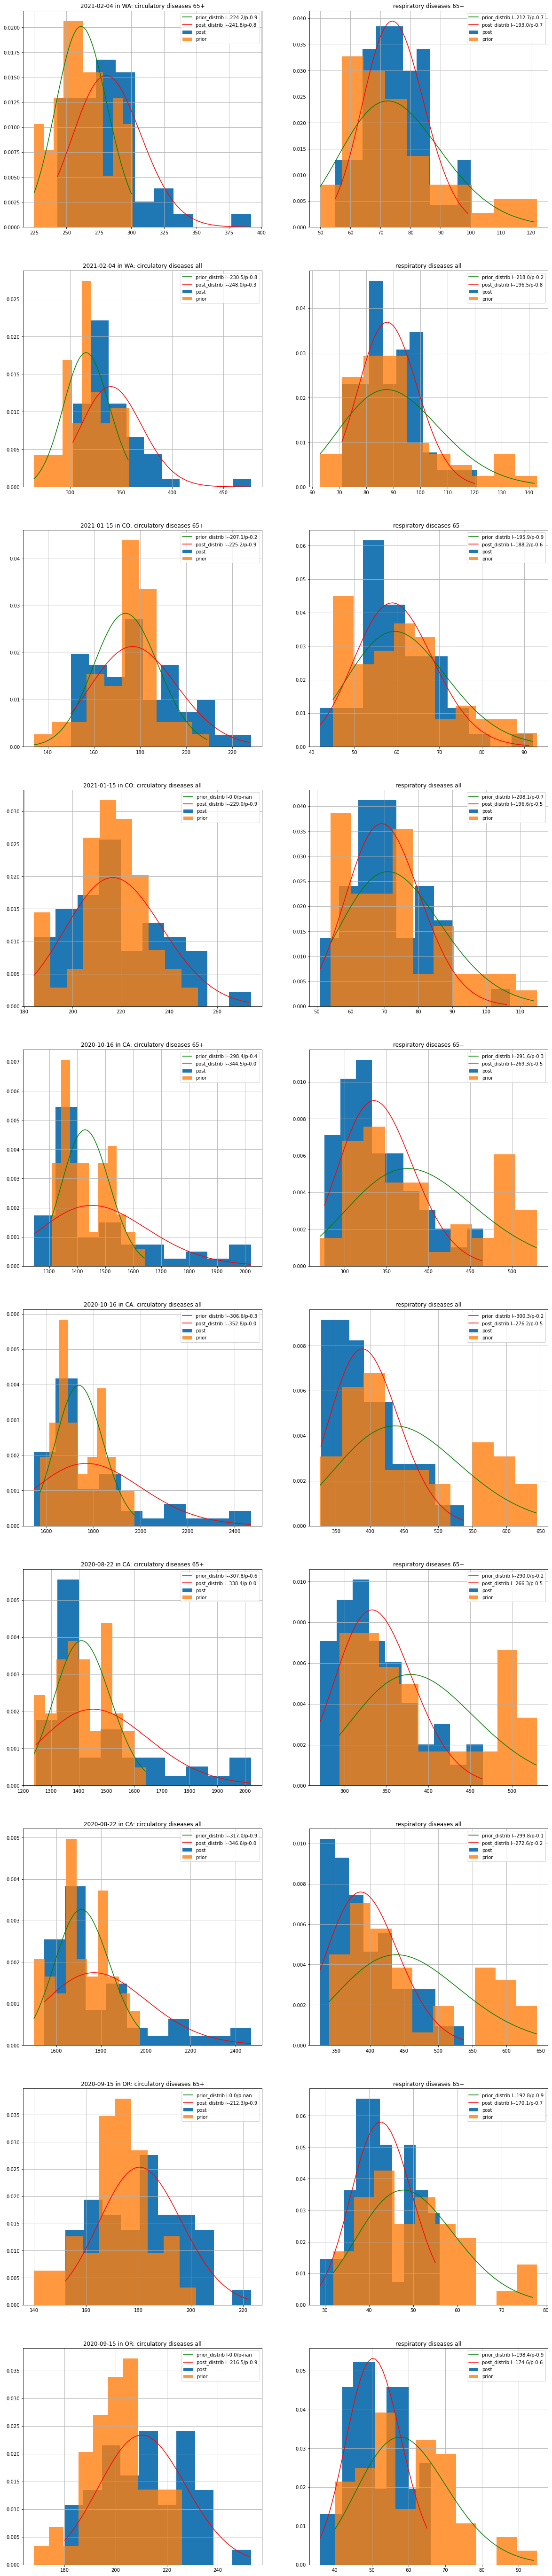

In [5]:
import matplotlib.pyplot as plt

from scipy.stats import nbinom
from scipy.stats import kstest

# return (p,r) moment estimation
statistics_ = lambda mean, var: {
    "r": mean ** 2 / (var - mean),
    "p": mean / var,
}


split_event = lambda df: (
    df[(df.index > 0) & (df.index < 12 * 30)],
    df[(df.index < 0) & (df.index > -12 * 30)],
)

n_categories = len(next(iter(df_temporel)))
n_events = len(df_temporel)

n_lines = n_events*n_categories

fig, axs = plt.subplots(n_lines, n_categories, figsize=(20, 100))

for index, (meta, df_dict) in enumerate(df_temporel.items()):
    time, location = meta
    date = str(time).split(" ")[0]
    
    for n_category, (category, df_) in enumerate(df_dict.items()):
    #df_ = df_dict['65+']
        x, y = df_.cirdeaths.astype(int), df_.resdeaths.astype(int)
        x_post, x_prior = split_event(x)
        y_post, y_prior = split_event(y)
        
        #law regression
        
        x_ = {"prior": x_prior, "post": x_post}
        y_ = {"prior": y_prior, "post": y_post}
        moments_x = {key: (data.mean(), data.var()) for key, data in x_.items()}
        moments_y = {key: (data.mean(), data.var()) for key, data in y_.items()}
        
        #fit_ = {key: sm.NegativeBinomial(*v).fit() for key, v in hist_.items()}
        parameters_moments_x = {k: statistics_(*v) for k, v in moments_x.items()}
        parameters_moments_y = {k: statistics_(*v) for k, v in moments_y.items()}
        
        r,p = parameters_moments_x["prior"]["r"], parameters_moments_x["prior"]["p"]
        x_plot = np.arange(x_prior.min(), x_prior.max())#nbinom.ppf(0.01, r, p), nbinom.ppf(0.99, r, p))
        likehood = x_prior.map(lambda val: nbinom.logpmf(val, r, p)).sum()
        p_value = kstest(x_prior, lambda x: nbinom.cdf(x, r, p)).pvalue
        #should make a loop
        #x
        axs[index*n_categories+n_category, 0].plot(
            x_plot,
            nbinom.pmf(x_plot, r, p),
            label=f"prior_distrib l-{likehood:.1f}/p-{p_value:.1f}",
            color="green",
        )
        
        r,p = parameters_moments_x["post"]["r"], parameters_moments_x["post"]["p"]
        x_plot = np.arange(x_post.min(), x_post.max())#nbinom.ppf(0.01, r, p), nbinom.ppf(0.99, r, p))
        likehood = x_post.map(lambda val: nbinom.logpmf(val, r, p)).sum()
        p_value = kstest(x_post, lambda x: nbinom.cdf(x, r, p)).pvalue
        
        axs[index*n_categories+n_category, 0].plot(
            x_plot,
            nbinom.pmf(x_plot, r, p),
            label=f"post_distrib l-{likehood:.1f}/p-{p_value:.1f}",
            color="red",
        )
        
        #y
        r,p = parameters_moments_y["prior"]["r"], parameters_moments_y["prior"]["p"]
        x_plot = np.arange(y_prior.min(), y_prior.max())#nbinom.ppf(0.01, r, p), nbinom.ppf(0.99, r, p))
        likehood = y_prior.map(lambda val: nbinom.logpmf(val, r, p)).sum()
        p_value = kstest(y_prior, lambda x: nbinom.cdf(x, r, p)).pvalue
        
        axs[index*n_categories+n_category, 1].plot(
            x_plot,
            nbinom.pmf(x_plot, r, p),
            label=f"prior_distrib l-{likehood:.1f}/p-{p_value:.1f}",
            color="green",
        )
        
        r,p = parameters_moments_y["post"]["r"], parameters_moments_y["post"]["p"]
        x_plot = np.arange(y_post.min(), y_post.max())#nbinom.ppf(0.01, r, p), nbinom.ppf(0.99, r, p))
        likehood = y_post.map(lambda val: nbinom.logpmf(val, r, p)).sum()
        p_value = kstest(y_post, lambda x: nbinom.cdf(x, r, p)).pvalue
        
        axs[index*n_categories+n_category, 1].plot(
            x_plot,
            nbinom.pmf(x_plot, r, p),
            label=f"post_distrib l-{likehood:.1f}/p-{p_value:.1f}",
            color="red",
        )
        
        

        x_post.hist(ax=axs[index*n_categories+n_category, 0], label="post", density=True)
        x_prior.hist(ax=axs[index*n_categories+n_category, 0], alpha=0.8, label="prior", density=True)

        y_post.hist(ax=axs[index*n_categories+n_category, 1], label="post", density=True)
        y_prior.hist(ax=axs[index*n_categories+n_category, 1],label="prior", alpha=0.8, density=True)
         
        
        axs[index*n_categories+n_category, 0].legend()
        axs[index*n_categories+n_category, 0].set_title(f"{date} in {location}: circulatory diseases {category}")
        axs[index*n_categories+n_category, 1].legend()
        axs[index*n_categories+n_category, 1].set_title(f"respiratory diseases {category}")
    
plt.legend()

In [9]:
from typing import Any, List
import pandas as pd



import numpy as np

from plotly.subplots import make_subplots
from plotly.validators.scatter.marker import SymbolValidator
import plotly.graph_objects as go
from typing import Dict

raw_symbols = SymbolValidator().values
namestems = []
namevariants = []
symbols = []
for i in range(0, len(raw_symbols), 3):
    name = raw_symbols[i + 2]
    symbols.append(raw_symbols[i])
    namestems.append(name.replace("-open", "").replace("-dot", ""))
    namevariants.append(name[len(namestems[-1]) :])

# def plot(df_temporel: Dict[pd.Timestamp: pd.DataFrame]):
"""Plot at each row death count in each category.

Args:
df_temporel (_type_): _description_
"""
rows = len(df_temporel)
cols = 2


# Create figure with secondary y-axis
fig = make_subplots(
    rows=rows,
    cols=2,
    specs=[[{"secondary_y": True}, {"secondary_y": True}] for _ in range(rows)],
)


def plot(fig:Any, df: pd.DataFrame, row:int, col:int, disaster_time:str, state: str, category:str, other_events:List[int]):
    # Left y
    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df.cirdeaths,
            name="Diseases of the circulatory system",
            mode="markers",
            marker=dict(
                color="rgb(27,158,119)",
            ),
            marker_symbol=symbols[namestems.index("circle-cross")],
            marker_line_width=2,
            marker_size=10,
            # showlegend=False,
        ),
        secondary_y=False,
        row=row,
        col=col,
    )

    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df.cirFiltered,
            marker=dict(
                color="rgb(27,158,119)",
            ),
        ),
        secondary_y=False,
        row=row,
        col=col,
    )
    #Right y
    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df.resdeaths,
            name="Diseases of the respiratory system",
            mode="markers",
            marker_symbol=symbols[namestems.index("circle-x")],
            marker=dict(
                color="rgb(297,95,2)",
            ),
            marker_line_width=1.5,
            marker_size=10,
            # showlegend=False,
        ),
        secondary_y=True,
        row=row,
        col=col,
    )

    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df.resFiltered,
            marker=dict(
                color="rgb(297,95,2)",
            ),
        ),
        secondary_y=True,
        row=row,
        col=col,
    )

    # Set x-axis title
    fig.update_xaxes(title_text=f"{disaster_time} in {state} on {category}", range=[-365.0, 365], row=row, col=col)

    # Set y-axes titles
    if col%2:
        fig.update_yaxes(
        title_text='<b style="color:rgb(297,95,2)">Respiratory Axis x</b>',
        secondary_y=True, row=row, col=col,
    )
    else:
        fig.update_yaxes(
            title_text='<b style="color:rgb(27,158,119)">Circulatory axis &#10010;</b> ',
            secondary_y=False, row=row, col=col,
        )
    
    fig.add_vline(x=0.0, line_color="rgb(117,112,79)", line_dash="dash")
    [fig.add_vline(x=shift, line_color="rgb(117,112,79)", line_dash="dash") for shift in other_events]

In [7]:
from utils import filter
for df_dict in df_temporel.values():
    for df_raw in df_dict.values():
        filter(df_raw)

In [10]:
from tqdm import tqdm

liste_ = list(df_temporel.keys())[:rows]


for row, (date, state) in enumerate(tqdm(liste_), start=1):
    shifts=[]
    max_shift = 365
    k = row-1
    
    time = str(date).split(" ")[0]
    for i in list(range(k-1,-1,-1))+list(range(k+1,len(liste_))):
        neighbor_time, neighbor_state = liste_[i]
        if neighbor_state==state:
            shifts.append(int((neighbor_time-pd.to_datetime(time))/ np.timedelta64(1, "D")))
        
    for col in [1, 2]:
        plot(
            fig=fig,
            df=df_temporel[(date, state)]["all"] if col % 2 else df_temporel[(date, state)]["65+"],
            row=row,
            col=col,
            disaster_time=time,
            state=state,
            other_events=shifts,
            category= "all" if col % 2 else "65+"
        )


fig.update_layout(title_text="Fire disasters", height= 1000*rows/3,plot_bgcolor='white')
fig.update_traces(showlegend=False)

# fig.update(layout_xaxis_range = [-365,365])

fig.show()

100%|██████████| 5/5 [00:04<00:00,  1.05it/s]
